<a href="https://colab.research.google.com/github/casoliveros95/2022-20-TalleresDL/blob/main/Taller%202/Taller_CSOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Taller 2**

Uno de los campos de aplicación de las técnicas de deep learning es la medicina, donde se han desarrollado sistemas que ayudan a los expertos en el diagnóstico y que facilitan la detección temprana de algunas patologías. Este es el caso de algunas enfermedades del ojo, las cuales pueden ser identificadas mediante un análisis automatizado de imágenes de la retina del paciente. De esta forma, se puede apoyar la toma de decisiones oportunas para prevenir la ceguera y otras complicaciones.


En este sentido, se quiere llevar a cabo un estudio, tomando como base imágenes de retina de retinopatía diabética, de cataratas y de glaucoma, para construir un modelo que apoye en la identificación de pacientes con riesgo de sufrir estas enfermedades.

Para la construcción del modelo, es importante que realicen su propia Red Neuronal para la clasificación de estas enfermedades. En donde es importante explorar tanto sus propias redes, como Redes Pre-entrenadas. Realice una tabla comparativa entre la Red Construida y por lo menos dos Redes Pre-entrenadas con la métrica seleccionada.

Datos: https://www.kaggle.com/datasets/gunavenkatdoddi/preprocessed-eye-diseases-fundus-images

# Integrantes
- Carlos Santiago Oliveros
- Juan Manuel Sáenz

# Análisis del problema
Se requiere realizar 3 modelos distintos de clasificación de imágenes, de multiples categorías (etiquetas excluyentes) correspondientes a las 3 enfermedades mencinadas anterioremente (retinopatía diabética, de cataratas y de glaucoma).

De acuerdo con la fuente de la información (https://www.kaggle.com/datasets/gunavenkatdoddi/preprocessed-eye-diseases-fundus-images), la base de datos:
- La base de datos, en realidad, contiene 4 catregorías: 3 enfermedades + 1 clase normal, sin enfermedades.
- La estructuración de la BD consiste en directorios de imágenes (carpetas) con las fotos de cada categoría.
- Las categorías están balanceadas, donde cada directorio tiene aprox. 1000 fotos.
- Los tamaños de las imágenes son a color (3 canales) de 300x300 pixeles.


# 0. Importación de librerías

In [ ]:
!pip install keras-tuner
!pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 9.9 MB/s 
     |████████████████████████████████| 1.6 MB 14.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras.preprocessing.image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement keras.preprocessing.image (from versions: none)
ERROR: No matching distribution found for keras.preprocessing.image


In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Reshape
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model
from IPython.display import Image

#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Rescaling, Lambda, MaxPooling2D, Conv2D, AveragePooling2D

import keras_tuner as kt
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.2


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Carga de la información
Primero, se monta la unidad de Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ahora, se cargan las credenciales para descargar directamente de Kaggle

In [ ]:
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Con esto, se puede descargar directamente la BD

In [ ]:
! kaggle datasets download -d gunavenkatdoddi/preprocessed-eye-diseases-fundus-images

 98% 461M/472M [00:05<00:00, 102MB/s]
100% 472M/472M [00:05<00:00, 91.8MB/s]


In [ ]:
!unzip preprocessed-eye-diseases-fundus-images.zip

Archive:  preprocessed-eye-diseases-fundus-images.zip
  inflating: seg_dataset/cataract/0_left.jpg  
  inflating: seg_dataset/cataract/103_left.jpg  
  inflating: seg_dataset/cataract/1062_right.jpg  
  inflating: seg_dataset/cataract/1083_left.jpg  
  inflating: seg_dataset/cataract/1084_right.jpg  
  inflating: seg_dataset/cataract/1102_left.jpg  
  inflating: seg_dataset/cataract/1102_right.jpg  
  inflating: seg_dataset/cataract/1115_left.jpg  
  inflating: seg_dataset/cataract/1126_right.jpg  
  inflating: seg_dataset/cataract/112_right.jpg  
  inflating: seg_dataset/cataract/1144_left.jpg  
  inflating: seg_dataset/cataract/1144_right.jpg  
  inflating: seg_dataset/cataract/1164_left.jpg  
  inflating: seg_dataset/cataract/1167_right.jpg  
  inflating: seg_dataset/cataract/119_left.jpg  
  inflating: seg_dataset/cataract/1285_left.jpg  
  inflating: seg_dataset/cataract/1415_left.jpg  
  inflating: seg_dataset/cataract/1415_right.jpg  
  inflating: seg_dataset/cataract/1435_left.

# 2. Preparación de la información


In [ ]:
batch_size = 32
img_height = 300
img_width = 300

Se utiliza la función image_dataset_from_directory de TensorFlow, dada la estructura de la información (por carpetas).

Se decidió para este ejercicio utilizar un label encoding para la categoría Y de clasificación. Un hiperparámetro alternativo podría ser probar con un one-hot encoding. Dado que se encontraron buenos resultados al final del ejercicio se dejó de esta manera.

De entrada, se define el 20% de los datos para validación.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_dataset',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_dataset',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


Se visualizan las clases y unos ejemplos de fotos:

In [ ]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


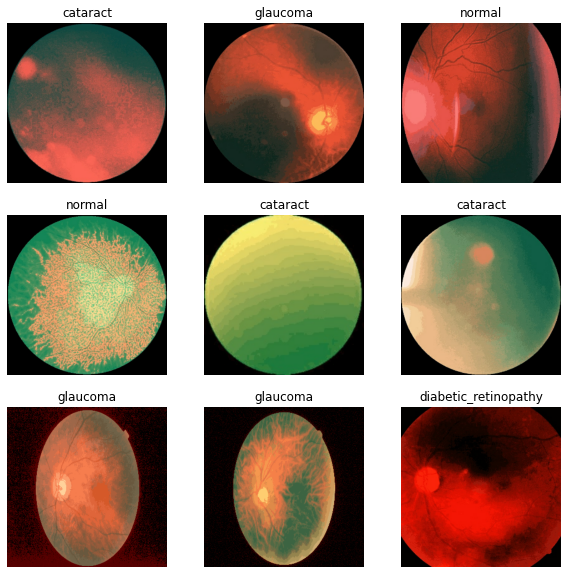

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        print(images[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

Se evidencia que las imágenes cargaron de forma adecuada y que se trata de imágenes a color como se mencionaba en los metadatos de la fuente.

# 3. Modelo original

## 3.1. Modelo base de referencia
Primero, se realizará el modelamiento de un modelo original de CNN que permita desarrollar la tarea de clasificación. 

Para tener una linea base y una medida de la dificultad de la tarea se hace un primer modelo rápido antes de la búsqueda detallada de hiperparámetros.

In [ ]:
# Generación
model = Sequential(name="Mi_primer_RNC")

# Capa de entrada (incluye que tiene colores: 3 de profundidad)
model.add(Input(shape=(img_height, img_width, 3),batch_size=None,name='Capa_Entrada'))

# Capa de reescalado
model.add(Rescaling(1./255,name='Capa_Reescalado'))

# Capas internas de encoder: se adicionan 2 dropouts para evitar sobreajuste
model.add(Conv2D(128, (3, 3), activation='relu', name='Capa_Convolucional_1'))
model.add(MaxPooling2D((2, 2), name='Max_Pool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', name='Capa_Convolucional_2'))
model.add(MaxPooling2D((2, 2), name='Max_Pool_2'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', name='Capa_Convolucional_3'))

# Capas internas de MLP para tarea de clasificación
# - Capa de vectorización
model.add(Flatten(name='Flatten_Layer'))

# - Capas de MPL
model.add(Dense(100,activation='relu',name='Capa_Densa_1'))
model.add(Dense(50,activation='relu',name='Capa_Densa_2'))

# Capa de salida
model.add(Dense(len(class_names),activation='softmax',name='Capa_Respuesta'))


Resumen:

In [ ]:
model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 300, 300, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 298, 298, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 149, 149, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 147, 147, 64)     73792     
 D)                                                              
                                                                 
 Max_Pool_2 (MaxPooling2D)   (None, 73, 73, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 73, 73, 64)      

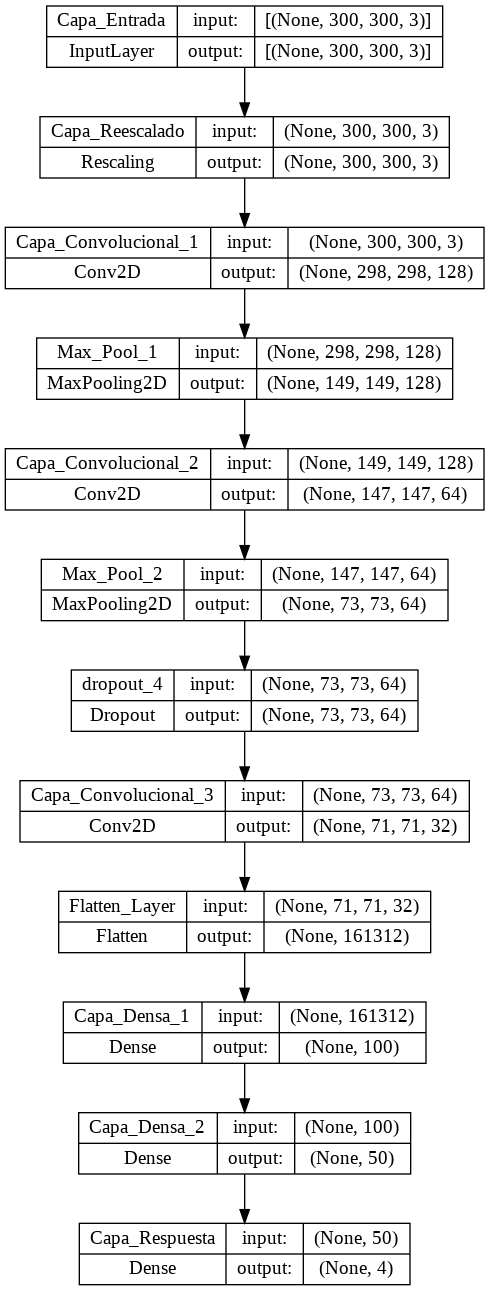

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

Compilación para optimización y entrenamiento:

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "Mi_primer_RNC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 300, 300, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 298, 298, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 149, 149, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 147, 147, 64)     73792     
 D)                                                              
                                                                 
 Max_Pool_2 (MaxPooling2D)   (None, 73, 73, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 73, 73, 64)      

Se adiciona un callback para Early Stopping

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

Entrenamiento:

In [ ]:
history = model.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
106/106 [==============================] - 1494s 14s/step - loss: 1.2561 - precision: 0.6751 - recall: 0.0948 - val_loss: 1.3964 - val_precision: 0.4615 - val_recall: 0.3843
Epoch 2/50
106/106 [==============================] - 1503s 14s/step - loss: 1.0067 - precision: 0.7153 - recall: 0.3112 - val_loss: 1.3820 - val_precision: 0.5399 - val_recall: 0.4899
Epoch 3/50
106/106 [==============================] - 1514s 14s/step - loss: 0.8601 - precision: 0.7181 - recall: 0.4348 - val_loss: 0.8698 - val_precision: 0.7019 - val_recall: 0.4721
Epoch 4/50
106/106 [==============================] - 1517s 14s/step - loss: 0.7981 - precision: 0.7486 - recall: 0.4908 - val_loss: 0.7944 - val_precision: 0.6968 - val_recall: 0.5397
Epoch 5/50
106/106 [==============================] - 1540s 15s/step - loss: 0.7521 - precision: 0.7508 - recall: 0.5243 - val_loss: 0.7774 - val_precision: 0.7262 - val_recall: 0.5255
Epoch 6/50
106/106 [==============================] - 1534s 14s/step - loss

Se descarga el modelo entranado.

In [ ]:
model.save('Original_LB.h5')

Ejemplo de predicción:

In [ ]:
y_true = list()
y_pred = list()

for images, labels in train_ds:
    pred = model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 [==============================] - 1s 1s/step


(array([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]], dtype=float32), array([[0, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        ...,
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]]))

Métricas de rendimiento:

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))


                      precision    recall  f1-score   support

            cataract       0.55      0.86      0.67       836
diabetic_retinopathy       0.96      0.99      0.97       884
            glaucoma       0.65      0.54      0.59       802
              normal       0.73      0.42      0.54       852

           micro avg       0.71      0.71      0.71      3374
           macro avg       0.72      0.70      0.69      3374
        weighted avg       0.73      0.71      0.70      3374
         samples avg       0.71      0.71      0.71      3374



Como primer ejercicio se encontraron buenos rendimientos. Sin embargo, este modelo se tomará unicamente como linea base para comparar con el modelo optimizado resultante de la búsqueda de hiperparámetros.

Finalmente, se visualizan algunos resultados.

1/1 [==============================] - 5s 5s/step


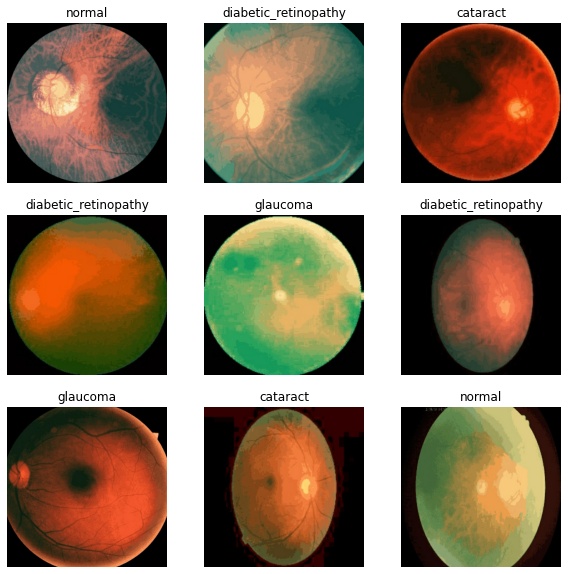

In [ ]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)
pred = model.predict(df)

for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

## 3.2 Búsqueda de hiperparámetros
Ahora, con el modelo base, se realiza una búsqueda de hiperparámetros.
Dada la estructura de la RN de CNN-MLP se definen los siguientes hiperparámetros:

 - Número de capas de CNN de extracción de características.
 - Número de filtros de las CNN.
 - Número de capas de MLP de modelo de clasificación.
 - Número de neuronas de las MLP.
 - Probabilidad de apagar neuronas en las capas de dropout.


 Dado el tipo de problema se tomaron las siguientes decisiones que no se variaron para este ejercicio:

 - La capa de salida tiene una función de activación softmax dado que se trata de un problema de clasificación multiclase.
 - Dadas las características del problema, además se utiliza como pérdida categorical_crossentropy.
 - Se buscó realizar una optimización ponderada de recall y precisión ya que dentro de las clases se encuentra una clase normal. Dado que los resultados finales encontraron un modelo suficientemente balanceados entre recall-precisión se decidió por mantener esta optimización.
 - Para facilitar la reducción de la dimensionalidad de la red, después de cada CNN se adicionó una capa de MaxPooling.
 - Para evitar el sobreajuste se incluyeron capas de Dropout.
 - Para evitar problemas de desbordamiento del gradiente se adicionó una capa de rescaling después de la entrada.
 - No obstante, dado que todos los valores son positivos se decidió por utilizar como función de activación ReLu para las CNN. Mientras que para la MLP se decidió por usar la función identidad.

In [ ]:
def entrenarRed(hp):
    clf = Sequential(name='Red_Encontrada')
    output = len(class_names)
    n_layers_DCN = hp.Choice('n_layers_DCN', [1, 2, 3])
    filtros = hp.Choice('filtros', ['[128, 64, 32]','[200, 100, 50]','[30, 120, 50]'])
    n_layers_MLP = hp.Choice('n_layers_MLP', [1, 2, 3])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[100, 50, 20]','[10, 20, 30]','[32, 16, 8]'])
    dropout = hp.Choice('dropout', [0.1,0.3,0.5])
    
    filtros = eval(filtros)
    neuronas_MLP = eval(neuronas_MLP)

    clf.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Input_Layer'))
    clf.add(Rescaling(1./255,name='Rescaling_Layer'))

    for i in range(n_layers_DCN):
        clf.add(Conv2D(filtros[i], (3, 3), activation='relu', name='Capa_Convolucional_{0}'.format(i)))
        clf.add(MaxPooling2D((2, 2), name='Max_Pool_{0}'.format(i)))

    clf.add(Flatten(name='Flatten_Layer'))
    for i in range(n_layers_MLP):
        clf.add(Dense(neuronas_MLP[i], activation='linear', name = 'Capa_Oculta_MLP_{0}'.format(i)))
        clf.add(Dropout(dropout,name='Dropout_{0}_{1}'.format(dropout,i)))

    clf.add(Dense(output, activation='softmax', name= 'Capa_Respuesta'))

    clf.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return clf

tuner = kt.RandomSearch(
    entrenarRed,
    objective="val_accuracy",
    project_name="Eye_detection",
    seed=123,
    max_trials=10)

Se hace corriendo la GPU y utilizando GridSearch por la dificultad de entrenamiento de la tarea.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

In [ ]:
with tf.device('/device:GPU:0'): 
    tuner.search(train_ds,
             validation_data=val_ds,
             callbacks=my_callbacks,
             epochs=30)
    
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 10m 02s]
val_accuracy: 0.7852906584739685

Best val_accuracy So Far: 0.7924080491065979
Total elapsed time: 01h 41m 21s


Se descarga el mejor modelo:

In [ ]:
best_model.save('best_model_original.h5')
best_model.summary()

Model: "Red_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_Layer (Rescaling)  (None, 300, 300, 3)      0         
                                                                 
 Capa_Convolucional_0 (Conv2  (None, 298, 298, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_0 (MaxPooling2D)   (None, 149, 149, 128)     0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 147, 147, 128)    147584    
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 73, 73, 128)       0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 71, 71, 128)   

Ahora, se calculan las métricas de rendimiento del modelo:

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 [==============================] - 0s 86ms/step


(array([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=float32), array([[0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ...,
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.81      0.64      0.72       202
diabetic_retinopathy       0.97      0.99      0.98       214
            glaucoma       0.71      0.65      0.68       205
              normal       0.70      0.86      0.77       222

           micro avg       0.79      0.79      0.79       843
           macro avg       0.80      0.79      0.79       843
        weighted avg       0.80      0.79      0.79       843
         samples avg       0.79      0.79      0.79       843



En general, se evidencia que de la búsqueda de hiperparámetros se obtuvo un modelo de buen desempeño promedio mejor que el modelo base inicial. Asimismo, se identifica que la clase con peor desempeño es la clase Glaucoma con precisión de 0.71, recall de 0.65 y f1-score de 0.77. Se identifica además, que la clase con mejores rendimientos es la clase diabetic_retinopathy.

Visualización de algunos resultados:

1/1 [==============================] - 1s 1s/step


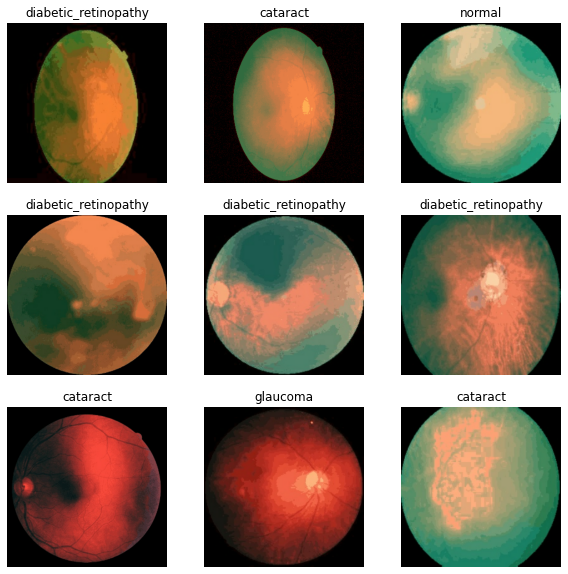

In [ ]:
model = tf.keras.models.load_model('best_model_original.h5')

plt.figure(figsize=(10, 10))

df = train_ds.take(1)
pred = model.predict(df)

for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

# 4. Modelo con transferencia de conocimiento: INCEPTIONV3
Ahora, se desarrolla un nuevo modelo utilizando transferencia de conocimiento tomando como módulo extractor de características a la red Inception. Se definió la red inception por su estructura de procesamiento de imágenes para tareas de clasificación (entre otras).

In [ ]:
#!pip install keras-tuner
#import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D

In [ ]:
base_model = InceptionV3(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet",
)

base_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

Para este caso se realiza la búsqueda de hiperparámetros de manera directa.

Dada la estructura de la RN de CNN (transferida) -MLP se definen los siguientes hiperparámetros:

 - Número de capas de MLP de modelo de clasificación.
 - Número de neuronas de las MLP.

 Dado el tipo de problema se tomaron las siguientes decisiones que no se variaron para este ejercicio:

 - La capa de salida tiene una función de activación softmax dado que se trata de un problema de clasificación multiclase.
 - Dadas las características del problema, además se utiliza como pérdida categorical_crossentropy.
 - Se buscó realizar una optimización ponderada de recall y precisión ya que dentro de las clases se encuentra una clase normal. Dado que los resultados finales encontraron un modelo suficientemente balanceados entre recall-precisión se decidió por mantener esta optimización.
 - Para procesar las características de la red transferida se adiciona una capa de Pooling antes de la red MLP.
 - Para evitar problemas de desbordamiento del gradiente se decidió utilizar funciones de activación linales para las capas del MLP.

In [ ]:
def entrenarRed(hp):
    clf = Sequential(name='Red_Encontrada')
    output = len(class_names)
    n_layers_MLP = hp.Choice('n_layers_MLP', [1, 2, 3])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[100, 50, 20]','[10, 20, 30]','[32, 16, 8]'])
    #Type_Optimizer = hp.Choice( 'Type_Optimizer' , ['sgd','adam'])

    neuronas_MLP = eval(neuronas_MLP)

    # Se adiciona el modelo base
    clf.add( base_model )

    # Se adiciona el pooling o flatten
    #clf.add(Flatten(name='Flatten_Layer'))
    clf.add(GlobalAveragePooling2D(name='Pooling'))
    
    # Se adicionan las capas del MLP
    for i in range(n_layers_MLP):
        clf.add(Dense(neuronas_MLP[i], activation='linear', name = 'Capa_Oculta_MLP_{0}'.format(i)))

    # Se adiciona la capa de salida
    clf.add(Dense(output, activation='softmax', name= 'Capa_Respuesta'))

    clf.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
        )
    return clf

tuner = kt.RandomSearch(
    entrenarRed,
    objective="val_acc",
    project_name="Eye_Detection2",
    seed=123,
    max_trials=10)

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping( patience=3 )
]

In [ ]:
with tf.device('/device:GPU:0'): 
    tuner.search(train_ds,
             validation_data=val_ds,
             callbacks=my_callbacks,
             epochs=50)


Trial 5 Complete [00h 06m 03s]
val_acc: 0.9110320210456848

Best val_acc So Far: 0.9228944182395935
Total elapsed time: 00h 41m 36s


In [ ]:
best_model = tuner.get_best_models()[0]

Se descarga el mejor modelo obtenido.

In [ ]:
best_model.save('best_model_inception.h5')
best_model.summary()

Model: "Red_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 Pooling (GlobalAveragePooli  (None, 2048)             0         
 ng2D)                                                           
                                                                 
 Capa_Oculta_MLP_0 (Dense)   (None, 10)                20490     
                                                                 
 Capa_Respuesta (Dense)      (None, 4)                 44        
                                                                 
Total params: 21,823,318
Trainable params: 21,788,886
Non-trainable params: 34,432
_________________________________________________________________


Ahora, se calculan las métricas de rendimiento del modelo.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 [==============================] - 1s 1s/step


(array([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]], dtype=float32), array([[0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        ...,
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.95      0.91      0.93       202
diabetic_retinopathy       1.00      1.00      1.00       214
            glaucoma       0.85      0.90      0.87       205
              normal       0.90      0.89      0.89       222

           micro avg       0.92      0.92      0.92       843
           macro avg       0.92      0.92      0.92       843
        weighted avg       0.92      0.92      0.92       843
         samples avg       0.92      0.92      0.92       843



Se visualizan algunos resultados:

1/1 [==============================] - 4s 4s/step


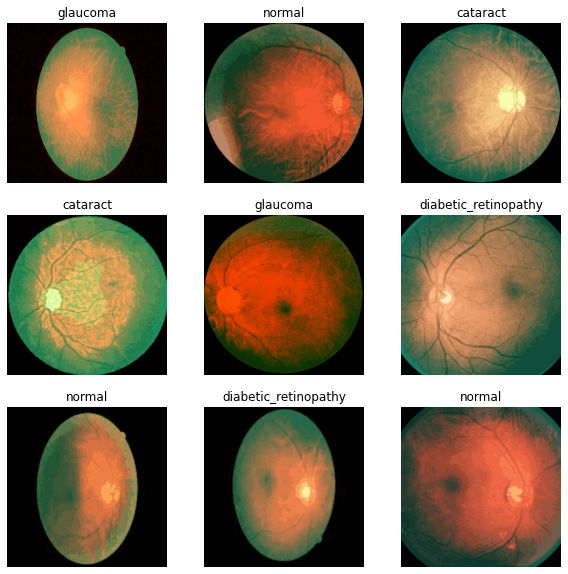

In [ ]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)
pred = best_model.predict(df)

for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

Del ejercicio anterior, se puede evidenciar de entrada una mejora significativa en los rendimientos del modelo. Obteniendo incluso un modelo con rendimientos mucho más balanceado entre las clases.

# 5. Modelo 2 con transferencia de conocimiento: VGG16
Ahora, se desarrolla un modelo alternativo de transferencia de conocimiento tomando como módulo de extractor de caraterísticas a la red VGG16. Se definió la red VGG16 por su estructura de capas recomendada o desarrollada precisamente para procesamiento de imágenes, al igual que la red inception, para tareas de clasficación (entre otras).

In [ ]:
base_model = tf.keras.applications.VGG16(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet",
)

base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                              

En esta oportunidad, se congela el modelo para solo entrenar la red MLP. Como alternativa al ejercicio de Inception.

In [ ]:
base_model.trainable = False

De igual forma, se realiza la búsqueda de hiperparámetros de manera directa.

Dada la estructura de la RN de CNN (transferida) -MLP se definen los siguientes hiperparámetros:

 - Número de capas de MLP de modelo de clasificación.
 - Número de neuronas de las MLP.

 Dado el tipo de problema se tomaron las siguientes decisiones que no se variaron para este ejercicio:

 - La capa de salida tiene una función de activación softmax dado que se trata de un problema de clasificación multiclase.
 - Dadas las características del problema, además se utiliza como pérdida categorical_crossentropy.
 - Se buscó realizar una optimización ponderada de recall y precisión ya que dentro de las clases se encuentra una clase normal. Dado que los resultados finales encontraron un modelo suficientemente balanceados entre recall-precisión se decidió por mantener esta optimización.
 - Para procesar las características de la red transferida se adiciona una capa de Pooling antes de la red MLP.
 - Para evitar problemas de desbordamiento del gradiente se decidió utilizar funciones de activación linales para las capas del MLP.

In [ ]:
def entrenarRed(hp):
    clf = Sequential(name='Red_Encontrada')
    output = len(class_names)
    n_layers_MLP = hp.Choice('n_layers_MLP', [1, 2, 3])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[100, 50, 20]','[10, 20, 30]','[32, 16, 8]'])
    #Type_Optimizer = hp.Choice( 'Type_Optimizer' , ['sgd','adam'])

    neuronas_MLP = eval(neuronas_MLP)

    # Se adiciona el modelo base
    clf.add( base_model )

    # Se adiciona el pooling o flatten
    #clf.add(Flatten(name='Flatten_Layer'))
    clf.add(GlobalAveragePooling2D(name='Pooling'))
    
    # Se adicionan las capas del MLP
    for i in range(n_layers_MLP):
        clf.add(Dense(neuronas_MLP[i], activation='linear', name = 'Capa_Oculta_MLP_{0}'.format(i)))

    # Se adiciona la capa de salida
    clf.add(Dense(output, activation='softmax', name= 'Capa_Respuesta'))

    clf.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
        )
    return clf

tuner = kt.RandomSearch(
    entrenarRed,
    objective="val_acc",
    project_name="Eye_Detection3",
    seed=123,
    max_trials=10)

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping( patience=3 )
]

In [ ]:
with tf.device('/device:GPU:0'): 
    tuner.search(train_ds,
             validation_data=val_ds,
             callbacks=my_callbacks,
             epochs=50)
    
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 14m 21s]
val_acc: 0.8576512336730957

Best val_acc So Far: 0.8600237369537354
Total elapsed time: 00h 56m 08s


Se guarda el mejor modelo.

In [ ]:
best_model.save('best_model_VGG6.h5')
best_model.summary()

Model: "Red_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 Pooling (GlobalAveragePooli  (None, 512)              0         
 ng2D)                                                           
                                                                 
 Capa_Oculta_MLP_0 (Dense)   (None, 10)                5130      
                                                                 
 Capa_Respuesta (Dense)      (None, 4)                 44        
                                                                 
Total params: 14,719,862
Trainable params: 5,174
Non-trainable params: 14,714,688
_________________________________________________________________


Ahora, se calculan las métricas del modelo.

In [ ]:
y_true = list()
y_pred = list()

for images, labels in val_ds:
    pred = best_model.predict(images)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())
        y_pred.append((pred[i] == pred[i].max()).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true, y_pred

1/1 [==============================] - 0s 153ms/step


(array([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]], dtype=float32), array([[1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        ...,
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0]]))

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(class_names)))

                      precision    recall  f1-score   support

            cataract       0.91      0.83      0.87       202
diabetic_retinopathy       0.94      0.94      0.94       214
            glaucoma       0.79      0.78      0.78       205
              normal       0.81      0.88      0.84       222

           micro avg       0.86      0.86      0.86       843
           macro avg       0.86      0.86      0.86       843
        weighted avg       0.86      0.86      0.86       843
         samples avg       0.86      0.86      0.86       843



Se visualizan algunas imágenes:

1/1 [==============================] - 2s 2s/step


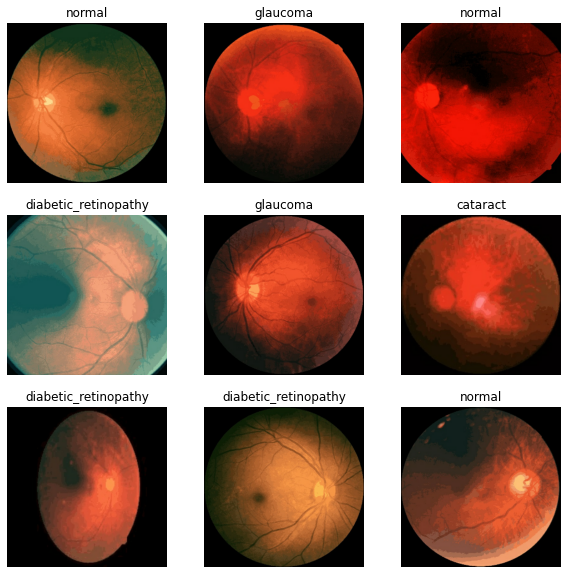

In [ ]:
plt.figure(figsize=(10, 10))

df = train_ds.take(1)
pred = best_model.predict(df)

for images, labels in df:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[pred[i].argmax()])
        plt.axis("off")

Se evidencia una mejora en todas las clases y en el rendimiento ponderado de la red. Sin embargo, se evidencia que los rendimientos del modelo construido con la red inception se comporta mejor.

# 6. Comparaciones y conclusiones

A continuación se resumen algunas métricas de los rendimientos  de los tres modelos.


- Con respecto a su precisión:

| Precision\Modelo | Original | Inception | VGG6 |
|----|----|----|----|
| Promedio | 0.80 | 0.92 | 0.86 |
| Max | 0.70 | 1.00 | 0.94 |
| Min | 0.71 | 0.85 | 0.79 | 

- Con respecto a su recall:

| Recall\Modelo | Original | Inception | VGG6 |
|----|----|----|----|
| Promedio | 0.79 | 0.92 | 0.86 |
| Max | 0.99 | 1.00 | 0.94 |
| Min | 0.64 | 0.89 | 0.78 | 

Los tres modelos corresponden a los resultados obtenidos optimizando de acuerdo a su ACCURACY, PRECISIÓN y RECALL (en este orden). Se definió que este era el criterio de mayor importancia para que presentara las estimaciones con menores errores posibles tanto de FN como de FP. Al final, se dejó este rendimiento balanceado ya que como se puede evidenciar a la tabla resumen se obtuvieron rendimientos balanceados para ambas métricas.

De los rendimientos anteriores se puede concluir que:
- Los modelos presentaron rendimientos ponderados equilibrados entre precisión y recall.
- Se evidencia una clara mejora en el rendimiento de los modelos construidos con transferencia de conocimiento. Siendo de peor a mejor: el modelo 100% original, el modelo con base en VGG6 y el modelo con base de InceptionV3.
- El modelo de peor desempeño promedio fue el modelo original de CNN-MLP. Sin embargo, su rendimiento no es necesariamente malo. Se obtuvieron métricas superiores a 0.70 en precisión y a 0.60 en recall.
- El modelo de mejor rendimiento es el de base de Inception. Se obtuvieron métricas de recall y precisión de 0.85, en el peor de los casos, y rendimientos ponderados de 0.92.
- El modelo con base en inception a pesar de que no se diferencia en términos ponderados significativamente del modelo 100% original, se evidencia una clara mejora para las clases de mayor dificultad. De forma que su peor rendimiento para las clases fue de 0.78-0.79 en recall y precisión respectivamente.
- Del ejercicio de los tres modelos de clasificación se puede evidenciar la ventaja de usar CNN para la extracción de características. Asimismo, al incluir redes muy profundas pre-entrenadas se observó la mejora en las capacidades de los modelos. 
- Finalmente, al negocio se le recomendaría usar el modelo basado en InceptionV3: con rendimientos ponderados de precisión y recall.
